# Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import glob
import cv2
import os

%matplotlib inline

# Lane Detection Pipeline

This section performs the following operations to detect (and draw) lanes in a frame:

1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform
5. Histogram peak extraction
6. Sliding window lane search
7. Searching from prior lane bounds (look-ahead filter)
8. Inverse perspective transform


## Basic Test Pipeline

A basic pipeline will be developed to test on a set of test images. This provides core functionality to the entire pipeline, and includes the following:

### Image Pre-Processing
1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform

### Lane Detection
1. Histogram peak extraction
2. Sliding window lane search

### Visualization
1. Inverse perspective warp

# Classes

In [197]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 

# Helper Functions

### Camera Calibration Helper Functions

In [2]:
def calibrate(images=[], nx=5, ny=5, vis=False, verbose=False):
    '''
    Calculates the camera calibration matrix and distortion coefficients using a sample of chessboard images. Grid size must be specified as the number of non-edge corners on the chessboard image.
    '''
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in the image plane

    # nx Number of grids in x-axis
    # ny Number of grids in y-axis

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    valid_images = 0
    total_images = len(images)

    for image in images:
        img = mpimg.imread(image)
        # Creating a grayscale image for the corner detection
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        #TODO: Add 8-bit image check, which is necessary if a .png is imported instead of a .jpg
        # Conversion is (gray*255).astype(np.uint8)

        # Finding chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If corners are found, add the object and image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            valid_images += 1
            # Visualize the corners
            if vis == True:
                img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
                plt.imshow(img)
                plt.show()

    if verbose == True:
        print('{} of the {} calibration images were valid'.format(valid_images, total_images))

    # Calibrate the camera using the object and image points    
    ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvec, tvec

### Sobel Helper Functions

In [3]:
def abs_sobel_thresh(image=None, orient='x', sobel_kernel=3, thresh=(0, 255), gray=None):
    '''
    Returns a binary image based on the threshold of direction of a Sobel operation.
    '''
    # Calculate directional gradient
    # Apply threshold
    if gray is None and image is not None:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobel = None
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Creating a thresholded sobel
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Creating a binary mask
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return grad_binary

def mag_thresh(image=None, sobel_kernel=3, mag_thresh=(0, 255), gray=None):
    '''
    Returns a binary image based on the magnitude of a sobel operation.
    '''
    if gray is None and image is not None:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Magnitude of the Sobel
    abs_sobel = np.sqrt(np.add(np.power(sobelx, 2), np.power(sobely, 2)))

    # Creating a thresholded sobel
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Creating binary mask
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(image=None, sobel_kernel=3, thresh=(0, np.pi/2), gray=None):
    '''
    Returns a binary image based on the threshold of the gradient of a Sobel operation.
    '''
    if gray is None and image is not None:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Computing Sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Computing sobel gradients
    grad = np.arctan2(abs_sobely, abs_sobelx)
    
    # Creating binary mask based on thresholds
    dir_binary = np.zeros_like(grad)
    dir_binary[(grad >= thresh[0]) & (grad <= thresh[1])] = 1

    return dir_binary

### Contrast-Limited Adaptive Histogram Equalization (CLAHE) Helper Functions

In [4]:
def normalize_image(image, clip_limit=3.0, tile_size=(30,30)):
    '''
    Normalize the histogram using CLAHE for an RGB image.
    '''
    # create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    normalized = image.copy()

    normalized[:,:,0] = clahe.apply(normalized[:,:,0])
    normalized[:,:,1] = clahe.apply(normalized[:,:,1])
    normalized[:,:,2] = clahe.apply(normalized[:,:,2])

    return normalized

### Color Mask Helper Functions

In [5]:
def white(hls, thresh=(225, 255)):
    '''
    Returns a binary image with whites extracted from the image. 
    Requires image to be in the HLS colorspace.
    '''
    hls = np.copy(hls)

    l_channel = hls[:,:,1] 
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    
    return l_binary  

def yellow(hls, thresh_h=(10, 54), thresh_s=(80, 255)):
    '''
    Returns a binary image with yellow hues from the image. 
    Requires image to be in the HLS colorspace.
    '''
    hls = np.copy(hls)

    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh_s[0]) & (s_channel <= thresh_s[1])] = 1  
    
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= thresh_h[0]) & (h_channel <= thresh_h[1])] = 1
    
    yellow_binary = np.zeros_like(h_binary)
    yellow_binary[(s_binary == 1) & (h_binary == 1)] = 1
    
    return yellow_binary 

def color_mask(image):
    '''
    Applies a color filter for only yellow and whites corresponding to lanes.
    Returns the binary mask for the filter.
    '''
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    color_binary = np.zeros_like(image[:,:,0])
    color_binary[(yellow(hls) == 1) | (white(hls) == 1)] = 1
    
    return color_binary


In [6]:
# def color_mask(image, thresh=(0,255)):
#     '''
#     Returns a binary image with thresholds applied to the saturation channel of the image.
#     '''
#     hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#     s_channel = hls[:,:,2]
    
#     color_binary = np.zeros_like(s_channel)
#     color_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1

#     return color_binary

In [7]:
def light_mask(image, thresh=(0,255)):
    '''
    Returns a binary image with thresholds applied to the saturation channel of the image.
    '''
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    
    light_binary = np.zeros_like(l_channel)
    light_binary[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1

    return light_binary

### Perspective Warp Helper Functions

In [26]:
def warp(image, src=None, dst=None, inverse=False):
    '''
    Perform a perspective warp on an undistorted image, from src points to dst points.
    src and dst are np.float32([[], [], []...])
    '''
    warped = None
    if src is None:
        # Average lane points from source image
        src = np.float32([
            [245, image.shape[0]],
            [600, 450],
            [670, 450],
            [965, image.shape[0]]
        ])

    if dst is None:
        # Perspective Warp which transforms to a straight lane
        offset = 50 # offset helps to maintain image aspect ratio
        dst = np.float32([
            [450, image.shape[0]-offset],
            [450, offset],
            [800, offset],
            [800, image.shape[0]-offset]
        ])
    if inverse == True:
        # Calculate the inverse transform
        M = cv2.getPerspectiveTransform(dst, src)
    else:
        # Calculate the forward transform
        M = cv2.getPerspectiveTransform(src, dst)
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

### Histogram Peak Extraction Helper Function

In [9]:
def hist_peaks(binary_warped):
    '''
    Returns the left and right histogram peaks for a given warped binary image.
    '''
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = binary_warped[binary_warped.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    left_peak = np.argmax(histogram[:midpoint])
    right_peak = np.argmax(histogram[midpoint:]) + midpoint
    
    return left_peak, right_peak

### Sliding Window Helper Functions

In [10]:
def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=50, vis=False, lanes_only=True, draw_rect=False):
    '''
    Performs a sliding window search for lane lines in a given warped binary image.
    '''
    out_img = None
    if vis == True:
        weight = 0
        if lanes_only == False:
            weight = 255
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*weight
    
    # Find the base of the lane lines using histogram peaks
    leftx_base, rightx_base = hist_peaks(binary_warped)

    # HYPERPARAMETERS
    # Number of sliding windows
    # nwindows = 9
    # Width of the windows +/- margin
    # margin = 100
    # Minimum number of pixels found to recenter window
    # minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Window boundaries
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin 
        win_xright_high = rightx_current + margin 
        
        if out_img is not None and draw_rect is True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = np.where(
                            (nonzeroy >= win_y_low) & 
                            (nonzeroy < win_y_high) & 
                            (nonzerox >= win_xleft_low) & 
                            (nonzerox < win_xleft_high)
                            )[0]
        good_right_inds = np.where(
                            (nonzeroy >= win_y_low) & 
                            (nonzeroy < win_y_high) & 
                            (nonzerox >= win_xright_low) & 
                            (nonzerox < win_xright_high)
                            )[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # Recenter the next window if > minpix pixels are found
        # based on the mean position of the pixels
        if good_left_inds.size > minpix:
            leftx_current = np.mean(nonzerox[good_left_inds], dtype=np.int32)

        if good_right_inds.size > minpix:
            rightx_current = np.mean(nonzerox[good_right_inds], dtype=np.int32)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, first_search=True, vis=False, lanes_only=True, draw_rect=False, draw_fit=False):
    '''
    Fits a polynomial to the coordinates of a found lane line.
    Returns the coefficients of the polynomial for the left and right lane lines
    and a visualization if requested.

    Corresponding coefficients are:
    x^2: x_fit[0]
    x: x_fit[1]
    c: x_fit[2]

    '''
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, vis=vis, lanes_only=lanes_only, draw_rect=draw_rect)
   
    left_fit, right_fit = [None]*2
    # Fit a second order polynomial to each using `np.polyfit`
    # Requires both lanes to be found
    if leftx.any() and lefty.any() and rightx.any() and righty.any():
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

    if vis == True:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = None
            right_fitx = None
        
        if left_fitx is not None and right_fitx is not None:
            ## Visualization ##
            # Colors in the left and right lane regions
            out_img[lefty, leftx] = [255, 0, 0]
            out_img[righty, rightx] = [0, 0, 255]

            # Plots the left and right polynomials on the lane lines
            # plt.plot(left_fitx, ploty, color='yellow')
            # plt.plot(right_fitx, ploty, color='yellow')
            if draw_fit == True:
                out_img[np.round(ploty).astype(np.int32), np.round(left_fitx).astype(np.int32)] = [255, 255, 0]
                out_img[np.round(ploty).astype(np.int32), np.round(right_fitx).astype(np.int32)] = [255, 255, 0]

    return left_fit, right_fit, out_img

### Look-Ahead Filter Helper Functions

In [54]:
def search_poly(binary_warped, left_fit=None, right_fit=None, margin=100, vis=False, lanes_only=True, draw_poly=False, draw_fit=False):
    '''
    Performs a lane search on a warped binary image, around previously found fitted lanes.
    Returns the new fitted polynomials for the left and right lanes. Visualization may be requested.

    Requires the left_fit and right_fit polynomial coefficients:
    left_fit = [[a],[b],[c]]
    '''
    # HYPERPARAMETER
    # Width of the margin around the previous polynomial to search
    # margin

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Placeholder for resulting image
    result = None

    if left_fit is not None and right_fit is not None:
    # Set the area of search based on activated x-values
    # within the +/- margin of our polynomial function
        left_lane_inds = np.where(
            (nonzerox > (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] - margin))
            & (nonzerox < (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] + margin))
            )
        right_lane_inds = np.where(
            (nonzerox > (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] - margin))
            & (nonzerox < (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] + margin))
            )
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each using `np.polyfit`
        # Requires both lanes to be found
        if leftx.any() and lefty.any() and rightx.any() and righty.any():
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
        
        if vis == True:
            ## Visualization ##
            # Create an image to draw on and an image to show the selection window
            weight = 0
            if lanes_only == False:
                weight = 255
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*weight
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[lefty, leftx] = [255, 0, 0]
            out_img[righty, rightx] = [0, 0, 255]

            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            try:
                left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
                right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                left_fitx = None
                right_fitx = None

            if left_fitx is not None and right_fitx is not None: 
                # Generate a polygon to illustrate the search window area
                # And recast the x and y points into usable format for cv2.fillPoly()
                left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
                left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                        ploty])))])
                left_line_pts = np.hstack((left_line_window1, left_line_window2))
                right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
                right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                        ploty])))])
                right_line_pts = np.hstack((right_line_window1, right_line_window2))
                
                if draw_fit == True:
                    # Plot the polynomial lines onto the image
                    out_img[np.round(ploty).astype(np.int32), np.round(left_fitx).astype(np.int32)] = [255, 255, 0]
                    out_img[np.round(ploty).astype(np.int32), np.round(right_fitx).astype(np.int32)] = [255, 255, 0]
                
                if draw_poly == True:
                    # Draw the lane onto the warped blank image
                    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
                    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
                
                result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
                
                # plt.plot(left_fitx, ploty, color='yellow')
                # plt.plot(right_fitx, ploty, color='yellow')
            ## End visualization steps ##
    
    return left_fit, right_fit, result

### Radius of Curvature Helper Functions

In [12]:
def curvature(height, left_fit, right_fit, x_scale=1, y_scale=1):
    '''
    Calculates the radius curvature of polynomial functions in meters.
    Requires x_scale and/or y_scale in meters per pixel and the height (in pixels)
    of the image from which the lines are generated. 

    `left` and `right_fit` are the fitted polynomials for the image in pixels.
    '''
    
    # Define y-value where we want radius of curvature
    # Generally this is the maximum y-value, corresponding to the bottom of the image
    y_eval = height*y_scale
    coeff_a_left = (x_scale/(y_scale**2))*left_fit[0]
    coeff_b_left = (x_scale/y_scale)*left_fit[1]

    coeff_a_right = (x_scale/(y_scale**2))*right_fit[0]
    coeff_b_right = (x_scale/y_scale)*right_fit[1]
    
    # Calculating the radius of curvature for both lanes at y_eval
    left_curverad = ((1+(2*coeff_a_left*y_eval + coeff_b_left)**2)**(3/2))/(np.absolute(2*coeff_a_left))
    right_curverad = ((1+(2*coeff_a_right*y_eval + coeff_b_right)**2)**(3/2))/(np.absolute(2*coeff_a_right))
    
    return left_curverad, right_curverad

### Lane Detection Pipeline Helper Functions

In [13]:
def detect_lanes(image, mtx, dist):
    '''
    Receives an input image and the camera matrix and distortion coefficients.
    Outputs the image with lane lines highlighted.
    '''

    # Undistort the image
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Apply a color and gradient mask
    col_mask = color_mask(dst, thresh=(175,255))
    grad_mask = abs_sobel_thresh(dst, orient='x', thresh=(20,100))

    colgrad_mask = np.zeros_like(image[:,:,0])
    colgrad_mask[(col_mask == 1) | (grad_mask == 1)] = 1

    # Perspective Transform
    warped_mask = warp(colgrad_mask)

    # Sliding Window Lane Detection
    left_fit, right_fit, out_img = fit_polynomial(warped_mask, vis=True, lanes_only=True, draw_rect=False, draw_fit=False)
    # left_fit, right_fit, out_img = search_poly(warped_mask, left_fit=left_fit, right_fit=right_fit, vis=True)
    
    return left_fit, right_fit, out_img




In [14]:
def detect_lanes_tracking(image, mtx, dist, left_lane=None, right_lane=None, col_thresh=(80,240), grad_thresh=(20,100), light_thresh=(125,255)):
    '''
    Receives an input image and the camera matrix and distortion coefficients.
    Outputs the image with lane lines highlighted.
    '''

    # Undistort the image
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    dst_eq = normalize_image(dst)

    # Apply a color and gradient mask
    grad_mask = abs_sobel_thresh(dst_eq, orient='x', thresh=(50,100))
    col_mask = color_mask(dst_eq)
    colgrad_mask = np.bitwise_or(col_mask, grad_mask)

    # Apply a lighting threshold mask
    lighting_mask = light_mask(dst_eq, thresh=(115,255))
    
    # Combining all masks
    combined_mask = np.zeros_like(colgrad_mask)
    combined_mask[(colgrad_mask == 1) & (lighting_mask == 1)] = 1
    
    # # Apply CLAHE for Gradient Thresholding
    # clahe_img = clahe_gray(dst)

    # # Apply a color and gradient mask
    # col_mask = color_mask(dst, thresh=col_thresh)
    # grad_mask = abs_sobel_thresh(gray=clahe_img, orient='x', thresh=grad_thresh)

    # colgrad_mask = np.zeros_like(image[:,:,0])
    # colgrad_mask[(col_mask == 1) | (grad_mask == 1)] = 1

    # wy_img = white_yellow_mask(dst)
    # wy_gray = cv2.cvtColor(wy_img, cv2.COLOR_RGB2GRAY)
    # wy_mask = np.zeros_like(wy_gray)
    # wy_mask[(colgrad_mask == 1) & (wy_gray >= 100) & (wy_gray <= 255)] = 1

    # # Apply a CLAHE mask
    # lightness_mask = light_mask(dst, thresh=light_thresh, clahe_clip=40.0)
    # # combined_mask = np.zeros_like(colgrad_mask)
    # # combined_mask[(colgrad_mask == 1) & (lightness_mask == 1)] = 1
    # combined_mask = np.zeros_like(wy_mask)
    # combined_mask[(wy_mask == 1) & (lightness_mask == 1)] = 1

    # Perspective Transform (with Region Mask)
    warped_mask = warp(combined_mask)
    warped_mask[:,:350] = 0
    warped_mask[:,1050:] = 0

    
    # Create temporary Line classes if none are passed
    if left_lane is None or right_lane is None:
        left_lane = Line()
        right_lane = Line()

    # Get the current parameters of the lane lines
    if not left_lane.current_fit[0].any() or not right_lane.current_fit[0].any():
        # Sliding Window Lane Detection
        left_fit, right_fit, out_img = fit_polynomial(warped_mask, vis=True, lanes_only=True, draw_rect=True, draw_fit=False)
    else:
        # Look-Ahead Filter Search
        left_fit = left_lane.current_fit
        right_fit = right_lane.current_fit
        left_fit, right_fit, out_img = search_poly(warped_mask, left_fit=left_fit, right_fit=right_fit, vis=True, draw_poly=True)

    # Update the lane parameters
    left_lane.current_fit = left_fit
    right_lane.current_fit = right_fit
    
    return left_fit, right_fit, out_img

In [15]:
def detect_lanes_tracking_class(image, mtx, dist, left_fit=np.array([False]), right_fit=np.array([False]), col_thresh=(80,240), grad_thresh=(20,100), light_thresh=(125,255)):
    '''
    Receives an input image and the camera matrix and distortion coefficients.
    Outputs the image with lane lines highlighted.
    '''

    # Undistort the image
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    dst_eq = normalize_image(dst)

    # Apply a color and gradient mask
    grad_mask = abs_sobel_thresh(dst_eq, orient='x', thresh=(50,100))
    col_mask = color_mask(dst_eq)
    colgrad_mask = np.bitwise_or(col_mask, grad_mask)

    # Apply a lighting threshold mask
    lighting_mask = light_mask(dst_eq, thresh=(115,255))
    
    # Combining all masks
    combined_mask = np.zeros_like(colgrad_mask)
    combined_mask[(colgrad_mask == 1) & (lighting_mask == 1)] = 1
    
    # Perspective Transform (with Region Mask)
    warped_mask = warp(combined_mask)
    warped_mask[:,:350] = 0
    warped_mask[:,1050:] = 0

    # Get the current parameters of the lane lines
    if not left_fit.any() or not right_fit.any():
        # Sliding Window Lane Detection
        left_fit, right_fit, out_img = fit_polynomial(warped_mask, vis=True, lanes_only=True, draw_rect=True, draw_fit=False)
    else:
        # Look-Ahead Filter Search
        left_fit, right_fit, out_img = search_poly(warped_mask, left_fit=left_fit, right_fit=right_fit, vis=True, draw_poly=True)
    
    return left_fit, right_fit, out_img

In [31]:
# Define a class to receive the characteristics of each line detection
class Line_Tracking():
    def __init__(self):
        # Number of fits to queue
        self.n_fits = 5
        # lane height
        self.height = 720
        # was the line detected in the last iteration?
        self.detected = False  
        # polynomial coefficients of the last n fits of the line
        self.all_fits = []   
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.array([False])   
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([False])  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 


    def update_curvature(self, height, fit, x_scale=1, y_scale=1):
        '''
        Calculates the radius curvature of polynomial functions in meters.
        Requires x_scale and/or y_scale in meters per pixel and the height (in pixels)
        of the image from which the lines are generated. 

        `left` and `right_fit` are the fitted polynomials for the image in pixels.
        '''
    
        # Define y-value where we want radius of curvature
        # Generally this is the maximum y-value, corresponding to the bottom of the image
        y_eval = height*y_scale
        coeff_a = (x_scale/(y_scale**2))*fit[0]
        coeff_b = (x_scale/y_scale)*fit[1]

        # Calculating the radius of curvature at y_eval
        _curvature = ((1+(2*coeff_a*y_eval + coeff_b)**2)**(3/2))/(np.absolute(2*coeff_a))
        # TODO: Implement curvature sanity check
        # if _curvature 
            # self.detected = np.bitwise_and(self.detected, True)
        self.radius_of_curvature = _curvature
        self.detected = np.bitwise_and(self.detected, True)

    def update_fit(self, fit):
        '''
        Updates the lane line polynomial coefficients.
        '''
        # Calculate polynomial coefficient differences
        # self.diffs = np.subtract(self.all_fits[-1], fit, axis=0)

        # Set a sanity check flag
        # TODO: Include logic here
        # if self.diffs
            # self.detected = np.bitwise_and(self.detected, True)
        # Update the fit
        self.current_fit = fit
        self.detected = np.bitwise_and(self.detected, True)

        # Update the queue of fits
        if len(self.all_fits) == self.n_fits:
            _tempfits = np.array(self.all_fits[1:])
            _tempfits = np.append(_tempfits, np.array([self.current_fit]), axis=0)
            self.all_fits = _tempfits.tolist()
        else:
            self.all_fits.append(self.current_fit)
        
        # Calculate the average fit
        self.best_fit = np.mean(self.all_fits, axis=0)

    def process_line(self, fit):
        # Reset sanity check flag
        self.detected = True

        # Update the line fit
        self.update_fit(fit)

        if self.detected:
            # Update the radius of curvature
            x_scale = 3.7/700
            y_scale = 30/self.height
            self.update_curvature(self.height, self.current_fit, x_scale=x_scale, y_scale=y_scale)

    def reset(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # polynomial coefficients of the last n fits of the line
        self.all_fits = []   
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([False])  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None   





In [57]:
def pipeline_tracking_class(image, left_lane, right_lane):
    '''
    Simple sliding window-based lane detection pipeline. Takes an image input and outputs an image with lane lines overlayed.
    '''
    left_fit = left_lane.best_fit
    right_fit = right_lane.best_fit
    left_fit, right_fit, out_img = detect_lanes_tracking_class(image, mtx, dist, left_fit=left_fit, right_fit=right_fit)

    # Update the lane parameters
    left_lane.process_line(left_fit)
    right_lane.process_line(right_fit)

    # Plot full lane
    if left_lane.best_fit.any() and right_lane.best_fit.any():
        l_fit = left_lane.best_fit
        r_fit = right_lane.best_fit

        # Generate x and y values for plotting
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
        left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
        right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]


        left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        lane_pts = np.hstack((left_line, right_line))

        cv2.fillPoly(out_img, np.int_([lane_pts]), (0,255, 0))

    # Unwarp image
    unwarp_binary = warp(out_img, inverse=True)
    final_img = cv2.addWeighted(image, 0.5, unwarp_binary, 0.8, 0)
    
    # ---------------------------------------------------------------------------------------------------------------
    # Appending Telemetry to the Frame
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 

    # org 
    org = (50, 50) 
    org_tel_offset = (50, 100) 

    # fontScale 
    fontScale = 1

    # Blue color in BGR 
    color = (255, 255, 255) 

    # Line thickness of 2 px 
    thickness = 2

    # Radius of Curvature Telemetry
    if left_lane.radius_of_curvature is not None and right_lane.radius_of_curvature is not None:
        avg_rad_curve = (left_lane.radius_of_curvature + right_lane.radius_of_curvature)/2
        if avg_rad_curve < 1000:
            if left_lane.radius_of_curvature > right_lane.radius_of_curvature:
                direction = 'm to the left'
            else:
                direction = 'm to the right'
            text = '{:.2f} {}'.format(avg_rad_curve, direction)
        else:
            text = 'Approximately straight'
    else:
        text = ''

    # Vehicle Offset Telemetry
    if left_lane.best_fit.any() and right_lane.best_fit.any():
        l_fit = left_lane.best_fit
        r_fit = right_lane.best_fit
        # Calculating the position of the lane lines closest to the vehicle
        l_base =  l_fit[0]*image.shape[0]**2 + l_fit[1]*image.shape[0] + l_fit[2]
        r_base =  r_fit[0]*image.shape[0]**2 + r_fit[1]*image.shape[0] + r_fit[2]
        # Calculating the offset in meters
        avg_base = np.mean([l_base, r_base])
        offset = (image.shape[1]/2 - avg_base)*3.7/700
    else:
        offset = np.NaN
    
    offset_text = '{:.2f}'.format(offset)
    
    # Using cv2.putText() method 
    final_img = cv2.putText(final_img, text, org, font,  
                    fontScale, color, thickness, cv2.LINE_AA) 

    final_img = cv2.putText(final_img, offset_text, org_tel_offset, font,  
                    fontScale, color, thickness, cv2.LINE_AA) 
# ---------------------------------------------------------------------------------------------------------------

    return final_img

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.098304/28549024 bytes (0.3%245760/28549024 bytes (0.9450560/28549024 bytes (1.6876544/28549024 bytes (3.11712128/28549024 bytes (6.0%2875392/28549024 bytes (10.13923968/28549024 bytes (13.74612096/28549024 bytes (16.24726784/28549024 bytes (16.65382144/28549024 bytes (18.95562368/28549024 bytes (19.56889472/28549024 bytes (24.17528448/28549024 bytes (26.47856128/28549024 bytes (27.58151040/28549024 bytes (28.69183232/28549024 bytes (32.210428416/28549024 bytes (36.5%11640832/28549024 bytes (40.8%12812288/28549024 bytes (44.9%14032896/28549024 bytes (49.2%15220736/28549024 bytes (53.3%16408576/28549024 bytes (57.5%17571840/28549024 bytes (61.5%18817024/28549024 bytes (65.9%19914752/28549024 bytes (69.8%21127168/28549024 bytes (74.0%22290432/28549024 bytes (78.1%2358476

In [58]:
left_lane = Line_Tracking()
right_lane = Line_Tracking()
# left_lane=None
# right_lane=None

test_output = 'test_output/test_tracking_test2.mp4'
# Uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip('project_video.mp4').subclip(20,27)
# clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(lambda image: pipeline_tracking_class(image, left_lane=left_lane, right_lane=right_lane)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_output/test_tracking_test2.mp4
[MoviePy] Writing video test_output/test_tracking_test2.mp4
 99%|█████████▉| 175/176 [00:14<00:00, 12.41it/s]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output/test_tracking_test2.mp4 

CPU times: user 50.9 s, sys: 12.3 s, total: 1min 3s
Wall time: 14.3 s


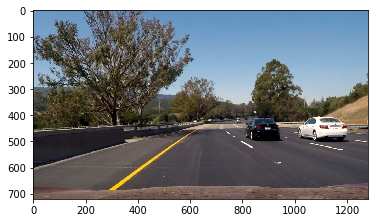

In [1008]:
plt.imshow(test_img)

In [1091]:
l_lane = Line_Tracking()
r_lane = Line_Tracking()

In [1088]:
l_lane.all_fits

[[0.0003164668184519511, -0.36819780199074126, 585.2002883288571],
 [0.0003568368251037031, -0.39814243087156126, 589.4907431900588],
 [0.00036328953351916026, -0.4055973724551536, 591.5624380788277],
 [0.0003630500280806626, -0.40799856919126565, 592.8787152478533],
 [0.000361908012215547, -0.4093111593510271, 593.8816376156967]]

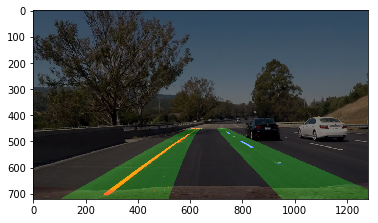

In [1087]:
plt.imshow(pipeline_tracking_class(test_img, l_lane, r_lane))

In [984]:
a=np.array([[1,2,3]])

In [993]:
b= np.append(a,[[2,3,4]], axis=0).tolist()
print(b)
np.mean(np.append(a,[[2,3,4]], axis=0).tolist(), axis=0)

[[1, 2, 3], [2, 3, 4]]


array([ 1.5,  2.5,  3.5])

In [988]:
a.tolist()

[[1, 2, 3]]

In [964]:
left_lane = Line()

In [969]:
np.array([False]).any()

False

## 1. Camera Calibration

In [18]:
images = glob.glob('camera_cal/calibration*.jpg')

In [19]:
# Calibrate the camera
ret, mtx, dist, rvec, tvec = calibrate(images, nx=9, ny=6, verbose=True)

17 of the 20 calibration images were valid


## 2. Distortion Correction

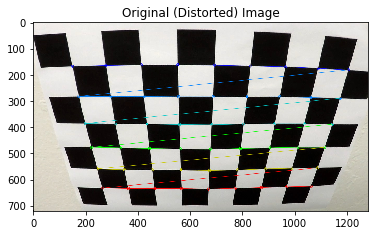

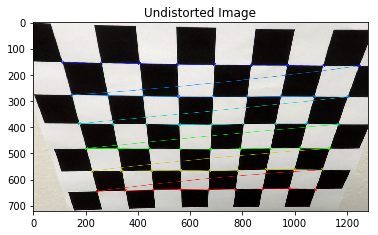

In [11]:
# Testing the calibration
test_img = mpimg.imread('camera_cal/calibration2.jpg')
test_gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
ret, corners = cv2.findChessboardCorners(test_gray, (9,6), None)
if ret == True:
    test_img = cv2.drawChessboardCorners(test_img, (9,6), corners, ret)
    plt.imshow(test_img)
    plt.title('Original (Distorted) Image')
    plt.show()

dst = cv2.undistort(test_img, mtx, dist, None, mtx)
plt.imshow(dst)
plt.title('Undistorted Image')
plt.show()

## 3. Color and Gradient Threshold

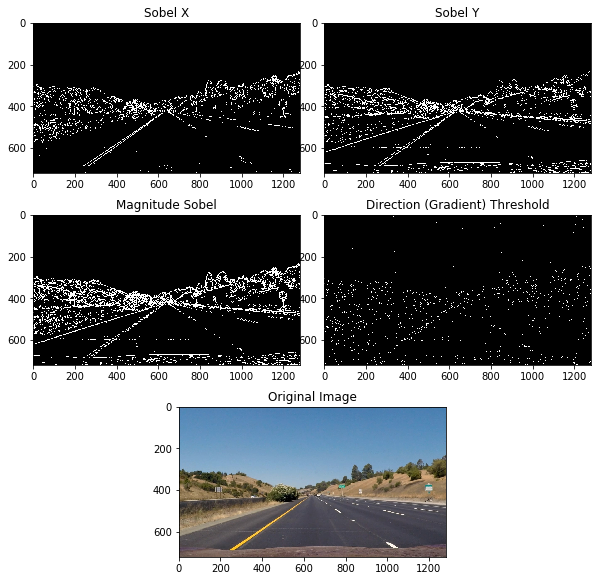

In [936]:
test_img = mpimg.imread('test_images/straight_lines1.jpg')

# Testing Sobel Operations
sobel_binx = abs_sobel_thresh(test_img, orient='x', thresh=(20,100))
sobel_biny = abs_sobel_thresh(test_img, orient='y', thresh=(20,100))
sobel_mag = mag_thresh(test_img, mag_thresh=(20,100))
# sobel_dir = dir_threshold(test_img, thresh=(0.53, 1.13))
sobel_dir = dir_threshold(test_img, thresh=(0.8, 0.9))

# Plotting Sobel Operation
gs = gridspec.GridSpec(3, 4)
gs.update(wspace=0.2, hspace=0.2)
plt.figure(figsize=(10,10))
ax0 = plt.subplot(gs[0, :2], )
ax1 = plt.subplot(gs[0, 2:])
ax2 = plt.subplot(gs[1, :2], )
ax3 = plt.subplot(gs[1, 2:])
ax4 = plt.subplot(gs[2, 1:3])

ax0.set_title('Sobel X')
ax1.set_title('Sobel Y')
ax2.set_title('Magnitude Sobel')
ax3.set_title('Direction (Gradient) Threshold')
ax4.set_title('Original Image')

ax0.imshow(sobel_binx, cmap='gray')
ax1.imshow(sobel_biny, cmap='gray')
ax2.imshow(sobel_mag, cmap='gray')
ax3.imshow(sobel_dir, cmap='gray')
ax4.imshow(test_img);


#### Sobel Note
> The X-direction Sobel operation performs the best, as it captures the most detail in lane lines with the least amount deail captured for the surroundings.

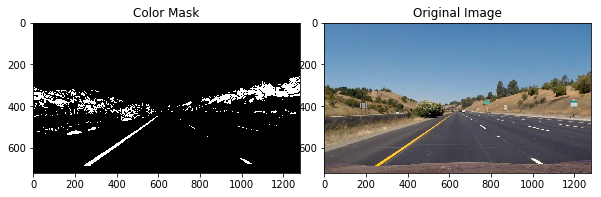

In [938]:
# Plotting Color Mask
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=0.2, hspace=0.2)
plt.figure(figsize=(10,10))
ax0 = plt.subplot(gs[0, :2], )
ax1 = plt.subplot(gs[0, 2:])

ax0.set_title('Color Mask')
ax1.set_title('Original Image')

ax0.imshow(color_mask(test_img), cmap='gray')
ax1.imshow(test_img);

#### Color and Graient Combined Mask

In [940]:
test_img = mpimg.imread('test_images/test6.jpg')

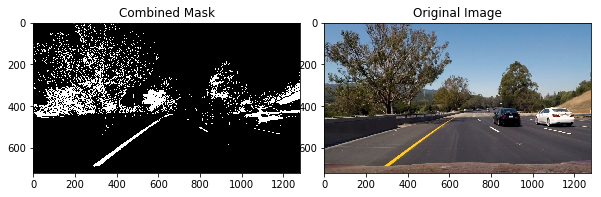

In [941]:
col_mask = color_mask(test_img)
grad_mask = abs_sobel_thresh(test_img, orient='x', thresh=(50,100))

colgrad_mask = np.zeros_like(test_img[:,:,0])
colgrad_mask[(col_mask == 1) | (grad_mask == 1)] = 1

# Plotting Color and Gradient Combined Mask
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=0.2, hspace=0.2)
plt.figure(figsize=(10,10))
ax0 = plt.subplot(gs[0, :2], )
ax1 = plt.subplot(gs[0, 2:])

ax0.set_title('Combined Mask')
ax1.set_title('Original Image')

ax0.imshow(colgrad_mask, cmap='gray')
ax1.imshow(test_img);

## 4. Perspective Transform

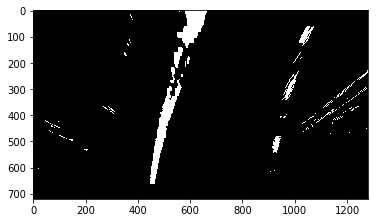

In [942]:
warped_mask = warp(colgrad_mask)
plt.imshow(warped_mask, cmap='gray');

## 5. Histogram Peak Extraction

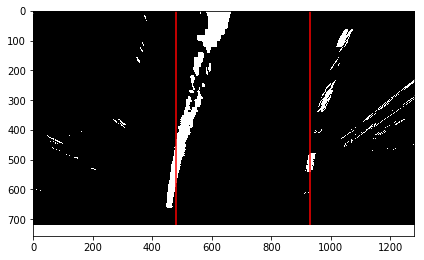

In [943]:
# Testing the peak detection on a warped binary image
plt.imshow(warped_mask, cmap='gray')
plt.vlines(x=np.asarray(hist_peaks(warped_mask)), ymin=0, ymax=warped_mask.shape[0], colors='r')
plt.tight_layout()
plt.show();

#### Note
> The histogram peak detection works well to find the *base* of the lane lines, i.e. the ones closest to the camera.

## 6. Sliding Window Lane Search

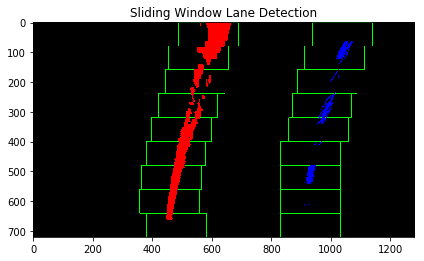

In [944]:
# Testing the sliding window lane detection with visualization
left_fit, right_fit, out_img = fit_polynomial(warped_mask, vis=True, lanes_only=True, draw_rect=True)
plt.title('Sliding Window Lane Detection')
plt.imshow(out_img)
plt.tight_layout();

## 7. Searching from Prior Lane Bounds (Look-Ahead Filter)

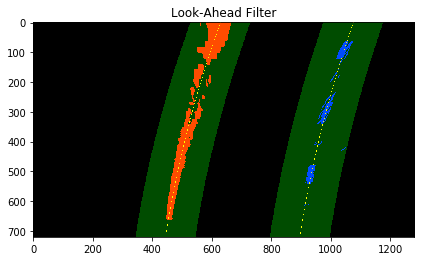

In [955]:
# Testing the look-ahead filter with visualization
_,_,out_img = search_poly(warped_mask, left_fit=left_fit, right_fit=right_fit, vis=True, draw_poly=True, draw_fit=True)
plt.title('Look-Ahead Filter')
plt.imshow(out_img)
plt.tight_layout();

#### Testing Radius of Curvature
> The resulting values here seem quite high, but that could make sense as the image is of more or less straight lines. Testing is required on a properly curved road.

In [956]:
x_scale = 3.7/warped_mask.shape[0]
y_scale = 30/warped_mask.shape[0]

left_radcurve, right_radcurve = curvature(warped_mask.shape[0], left_fit, right_fit, x_scale, y_scale)
print(left_radcurve, right_radcurve)

1174.28700636 1062.13190982


## 8. Inverse Perspective Transform

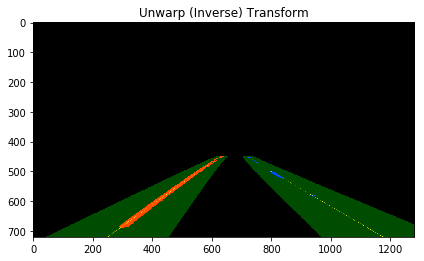

In [957]:
unwarp_binary = warp(out_img, inverse=True)
plt.title('Unwarp (Inverse) Transform')
plt.imshow(unwarp_binary, cmap='gray')
plt.tight_layout();

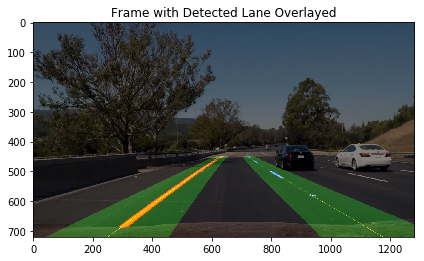

In [958]:
final_img = cv2.addWeighted(test_img, 0.5, unwarp_binary, 0.8, 0)
plt.title('Frame with Detected Lane Overlayed')
plt.imshow(final_img)
plt.tight_layout();

# Testing
## Lane Detection Pipeline

In [65]:
# Calibrate the camera
images = glob.glob('camera_cal/calibration*.jpg')
ret, mtx, dist, rvec, tvec = calibrate(images, nx=9, ny=6, verbose=True)

17 of the 20 calibration images were valid


### Single Frame Test

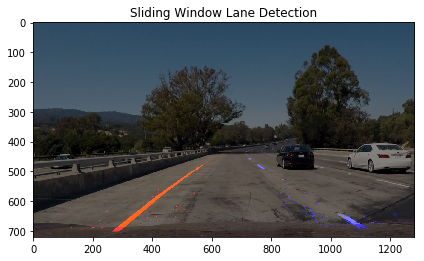

In [230]:
test_img = mpimg.imread('test_images/test1.jpg')
left_fit, right_fit, out_img = detect_lanes(test_img, mtx, dist)
unwarp_binary = warp(out_img, inverse=True)
final_img = cv2.addWeighted(test_img, 0.5, unwarp_binary, 0.8, 0)

plt.clf()
plt.title('Sliding Window Lane Detection')
plt.imshow(final_img)
plt.tight_layout();

### Multiple Single Frame Test

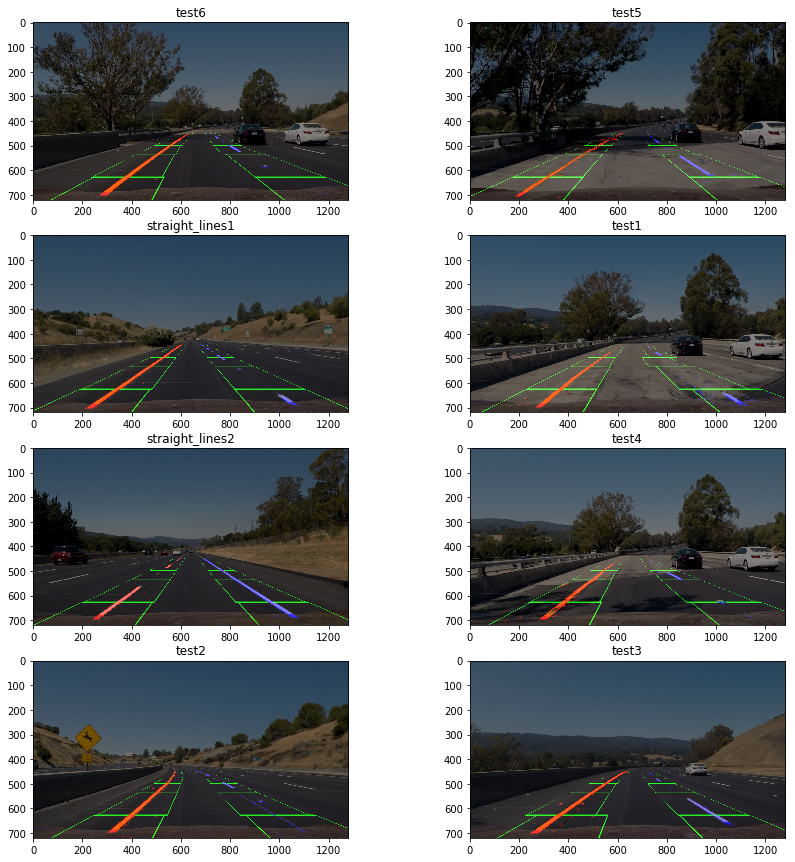

In [332]:
test_images = glob.glob('test_images/*.jpg')

# Creating a grid for test plots
gs = gridspec.GridSpec(len(test_images)//2, 4)
gs.update(wspace=0.2, hspace=0.2)
plt.figure(figsize=(15,15))
ax = []

for (i, image) in enumerate(test_images):
    img = mpimg.imread(image)
    left_fit, right_fit, out_img = detect_lanes_tracking(img, mtx, dist)
    unwarp_binary = warp(out_img, inverse=True)
    final_img = cv2.addWeighted(img, 0.5, unwarp_binary, 0.8, 0)
    
    # Append plots to a list
    if i%2:
        plot = plt.subplot(gs[i//2, 2:])
        plot.set_title(image[12:-4])
        plot.imshow(final_img)
        ax.append(plot)
    else:
        plot = plt.subplot(gs[i//2, :2], )
        plot.set_title(image[12:-4])
        plot.imshow(final_img)
        ax.append(plot)


> Notes: lane lines could not be detected in some images. This may be a result of thresholds being too aggressive. However, in most images the lane lines are very well detected. Parameter tuning is required.

## Tracking

In [198]:
left_lane = Line()
right_lane = Line()

In [199]:
left_lane.line_base_pos = [0,2]

In [200]:
left_lane.line_base_pos

[0, 2]

In [202]:
def lane_get(lane=Line()):
    print(lane.line_base_pos)
    lane.line_base_pos[0] += 1

In [207]:
lane_get(left_lane)

[4, 2]


In [222]:
left_lane.current_fit[0].any()

False

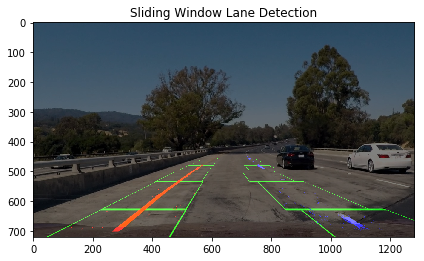

In [498]:
left_lane = Line()
right_lane = Line()

test_img = mpimg.imread('test_images/test1.jpg')
left_fit, right_fit, out_img = detect_lanes_tracking(test_img, mtx, dist, left_lane=left_lane, right_lane=right_lane)
unwarp_binary = warp(out_img, inverse=True)
final_img = cv2.addWeighted(test_img, 0.5, unwarp_binary, 0.8, 0)

plt.clf()
plt.title('Sliding Window Lane Detection')
plt.imshow(final_img)
plt.tight_layout();

# Pipeline Video Tests

In [194]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [195]:
def pipeline(image):
    '''
    Simple sliding window-based lane detection pipeline. Takes an image input and outputs an image with lane lines overlayed.
    '''
    left_fit, right_fit, out_img = detect_lanes(image, mtx, dist)
    unwarp_binary = warp(out_img, inverse=True)
    final_img = cv2.addWeighted(image, 0.5, unwarp_binary, 0.8, 0)
    return final_img

In [314]:
def pipeline_tracking(image, left_lane, right_lane):
    '''
    Simple sliding window-based lane detection pipeline. Takes an image input and outputs an image with lane lines overlayed.
    '''
    left_fit, right_fit, out_img = detect_lanes_tracking(image, mtx, dist, left_lane=left_lane, right_lane=right_lane)
    unwarp_binary = warp(out_img, inverse=True)
    final_img = cv2.addWeighted(image, 0.5, unwarp_binary, 0.8, 0)
    return final_img

In [1092]:
left_lane = Line()
right_lane = Line()
# left_lane=None
# right_lane=None

test_output = 'test_output/test_tracking_test.mp4'
# Uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip('project_video.mp4').subclip(20,27)
# clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(lambda image: pipeline_tracking(image, left_lane=left_lane, right_lane=right_lane)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_output/test_tracking_test_9.mp4
[MoviePy] Writing video test_output/test_tracking_test_9.mp4
 99%|█████████▉| 175/176 [00:14<00:00, 12.18it/s]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output/test_tracking_test_9.mp4 

CPU times: user 53.1 s, sys: 12.1 s, total: 1min 5s
Wall time: 14.6 s


In [193]:
test_output = 'test_output/test.mp4'
# Uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip('project_video.mp4').subclip(0,5)
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_output/test.mp4
[MoviePy] Writing video test_output/test.mp4
 49%|████▉     | 616/1261 [00:42<00:41, 15.51it/s]The function failed to fit a line!
The function failed to fit a line!
The function failed to fit a line!
The function failed to fit a line!
 49%|████▉     | 620/1261 [00:42<00:43, 14.82it/s]The function failed to fit a line!
The function failed to fit a line!
The function failed to fit a line!
 49%|████▉     | 624/1261 [00:43<00:41, 15.25it/s]The function failed to fit a line!
The function failed to fit a line!
 50%|████▉     | 628/1261 [00:43<00:40, 15.68it/s]The function failed to fit a line!
The function failed to fit a line!
The function failed to fit a line!
The function failed to fit a line!
 50%|█████     | 636/1261 [00:43<00:43, 14.47it/s]The function failed to fit a line!
The function failed to fit a line!
The function failed to fit a line!
 51%|█████     | 640/1261 [00:44<00:41, 14.85it/s]The function failed to fit a line!
The funct

In [932]:
# left_lane = Line()
# right_lane = Line()
left_lane = None
right_lane = None

challenge_output = 'test_output/test_challenge_beta4.mp4'
# Uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip('challenge_video.mp4').subclip(0,5)
# clip1 = VideoFileClip('challenge_video.mp4')
white_clip = clip1.fl_image(lambda image: pipeline_tracking(image, left_lane=left_lane, right_lane=right_lane)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_output/test_challenge_beta4.mp4
[MoviePy] Writing video test_output/test_challenge_beta4.mp4
100%|██████████| 150/150 [00:11<00:00, 13.33it/s]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output/test_challenge_beta4.mp4 

CPU times: user 44.3 s, sys: 10.3 s, total: 54.6 s
Wall time: 11.9 s
